<a href="https://colab.research.google.com/github/Fatikhaaa/submissionAkhirBPML-ImageClassification/blob/main/BPML_Image_Classififcation(fix).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Fatikha Hudi Aryani
- **Email:** fatikhahudiaryani621@gmail.com
- **ID Dicoding:** fatikha_hudi_aryani

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow==2.15.0

In [2]:
# install library Pillow (PIL Fork) untuk processing gambar
!pip install Pillow==8.4.0

In [3]:
!pip install googletrans==4.0.0-rc1

In [4]:
# Mencetak versi NumPy dan TensorFlow yang sedang digunakan
import numpy as np
import tensorflow as tf
print(f'Numpy version: {np.__version__}')
print(f'TensorFlow version: {tf.__version__}')

Numpy version: 1.26.4
TensorFlow version: 2.15.0


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import pathlib
import shutil
import cv2
import sys
from skimage import io, img_as_ubyte, transform
from skimage.transform import rotate, warp, AffineTransform
from skimage.exposure import adjust_gamma

from collections import defaultdict

# Import PIL untuk image processing
from PIL import Image

# Import matplotlib untuk plotting
import matplotlib.pyplot as plt

from googletrans import Translator
from googletrans import LANGUAGES

# Import Keras dan TensorFlow library
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

## Data Preparation

### Data Loading

Install package gdown di Python untuk mengunduh File dari Google Drive

In [6]:
# Memuat data
from google.colab import files
files.upload()  # Pilih file kaggle.json yang sudah didownload

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatikhaa","key":"eac54637b708ee058d962646c2eb8667"}'}

In [7]:
# Konfigurasi akses ke API Kaggle dari google colab
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Atur permission

In [9]:
!kaggle datasets list  # Cek apakah bisa mengakses API

ref                                                                  title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance                 Student Habits vs Academic Performance                19512  2025-04-12 10:49:08.663000           9747        166  1.0              
zahidmughal2343/global-cancer-patients-2015-2024                     global_cancer_patients_2015_2024                    1261049  2025-04-14 00:05:23.367000           2451         32  1.0              
shahriarkabir/procurement-kpi-analysis-dataset                       Procurement KPI Analysis Dataset                      16906  2025-04-26 02:15:11.127000            801         22  1.0     

In [10]:
# Download dataset dari kaggle dan unzip file
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-

> Mengubah nama folder dalam dataset dengan menerjemahkan nama folder ke bahasa lain

In [13]:
# Path ke direktori dataset
dataset_directory = 'raw-img'

# objek translator
translator = Translator()

# Buat dictionary untuk terjemahan nama folder
translate = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

# Loop melalui semua item dalam direktori dataset
for folder_name in os.listdir(dataset_directory):
    folder_path = os.path.join(dataset_directory, folder_name)  # Gabungkan path folder dengan nama folder

    # Cek apakah item tersebut adalah folder (bukan file)
    if os.path.isdir(folder_path):
        new_folder_name = translate.get(folder_name, None)  # Terjemahkan nama folder ke bahasa lain

        # Jika terjemahan berhasil ditemukan
        if new_folder_name:
            new_folder_path = os.path.join(dataset_directory, new_folder_name)  # Buat path baru dengan nama folder yang sudah diterjemahkan

            # Pindahkan/rename folder ke nama baru
            shutil.move(folder_path, new_folder_path)

> Menghitung jumlah gambar per folder dan total keseluruhan gambar dalam dataset

In [14]:
def count_images_with_total(dataset_directory):
    image_counts = {}
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff')
    total = 0  # Variabel untuk menyimpan total keseluruhan

    for folder_name  in os.listdir(dataset_directory):
        folder_path = os.path.join(dataset_directory, folder_name)

        if os.path.isdir(folder_path):
            count = 0
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(valid_ext):
                    try:
                        with Image.open(os.path.join(folder_path, filename)) as img:
                            img.verify()
                        count += 1
                    except Exception:
                        continue

            image_counts[folder_name] = count
            total += count  # Tambahkan ke total keseluruhan
            print(f"{folder_name}: {count} gambar")

    image_counts['TOTAL'] = total  # Tambahkan entry TOTAL
    print(f"\nToral Keseluruhan: {total} gambar")
    return image_counts

# Menapilkan hasil
dataset_path = "raw-img"
result = count_images_with_total(dataset_path)

cow: 1866 gambar
spider: 4821 gambar
horse: 2623 gambar
sheep: 1820 gambar
chicken: 3098 gambar
cat: 1668 gambar
squirrel: 1862 gambar
elephant: 1446 gambar
butterfly: 2112 gambar
dog: 4863 gambar

Toral Keseluruhan: 26179 gambar


Karena pada ketentuan submission dicoding yaitu gambar-gambar harus memiliki resolusi yang berbeda-beda maka dilakukan pengecekan untuk mengetahui resolusi pada tiap gambar.

In [15]:
# Menampilkan jumlah gambar pada masing-masing resolusi
def count_image_resolutions(dataset_dir):
    resolution_counts = defaultdict(int)

    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                try:
                    with Image.open(os.path.join(root, file)) as img:
                        resolution = img.size  # (width, height)
                        resolution_counts[resolution] += 1
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")
                    continue

    # Urutkan dari resolusi yang paling banyak
    sorted_counts = sorted(resolution_counts.items(),
                          key=lambda x: x[1],
                          reverse=True)

    return dict(sorted_counts)

# Contoh penggunaan
dataset_path = "raw-img"  # Ganti dengan path dataset Anda
resolution_counts = count_image_resolutions(dataset_path)

# Tampilkan hasil
print("Resolusi Gambar dan Jumlahnya:")
print("----------------------------")
print("Width x Height : Jumlah")
print("----------------------------")
for (width, height), count in resolution_counts.items():
    print(f"{width} x {height} : {count} gambar")

# Hitung total semua gambar
total_images = sum(resolution_counts.values())
print("\nTotal semua gambar:", total_images)

Resolusi Gambar dan Jumlahnya:
----------------------------
Width x Height : Jumlah
----------------------------
300 x 225 : 4397 gambar
300 x 200 : 3281 gambar
300 x 300 : 1192 gambar
300 x 169 : 1048 gambar
640 x 426 : 694 gambar
300 x 199 : 586 gambar
225 x 300 : 490 gambar
300 x 240 : 403 gambar
300 x 188 : 393 gambar
200 x 300 : 362 gambar
300 x 221 : 299 gambar
300 x 201 : 288 gambar
300 x 226 : 240 gambar
300 x 214 : 239 gambar
300 x 202 : 167 gambar
201 x 300 : 133 gambar
300 x 210 : 129 gambar
300 x 213 : 126 gambar
300 x 220 : 119 gambar
300 x 219 : 118 gambar
640 x 480 : 118 gambar
300 x 209 : 111 gambar
300 x 228 : 111 gambar
226 x 300 : 110 gambar
300 x 224 : 110 gambar
300 x 206 : 109 gambar
300 x 197 : 108 gambar
169 x 300 : 108 gambar
300 x 230 : 107 gambar
300 x 216 : 104 gambar
300 x 235 : 104 gambar
300 x 223 : 104 gambar
300 x 218 : 103 gambar
300 x 207 : 99 gambar
300 x 232 : 99 gambar
300 x 168 : 98 gambar
300 x 233 : 95 gambar
300 x 204 : 95 gambar
300 x 211 : 93

Dari hasil outputnya terlihat bahwa dari dataset yang digunakan, gambar yang ada didalamnya memiliki resolusi yang bervariasi.

### Data Preprocessing

Pada submission dicoding proyek klasifikasi gambar, jumlah dataset minimal yang digunakan yaitu 10.000. Sehingga pada proyek kali ini, hanya akan dipilih 3 kategori saja dari dataset animal. Kategori animal yang dipilih dan jumlah total dari dataset yang akan digunakan adalah sebagai berikut:

* spider: 4821 gambar
* dog: 4863 gambar
* horse: 2623 gambar

Toral : 12307 gambar

Menghapus semua folder dan menyisakan 3 folder terpilih saja .

In [16]:
def clean_dataset_folder(dataset_directory, keep_folders=['spider','dog','horse']):
    for item in os.listdir(dataset_directory):
        item_path = os.path.join(dataset_directory, item)
        if os.path.isdir(item_path) and item not in keep_folders:
            shutil.rmtree(item_path)
            print(f"Menghapus folder: {item_path}")

# Path ke folder utama
dataset_path = "raw-img"
clean_dataset_folder(dataset_path)

Menghapus folder: raw-img/cow
Menghapus folder: raw-img/sheep
Menghapus folder: raw-img/chicken
Menghapus folder: raw-img/cat
Menghapus folder: raw-img/squirrel
Menghapus folder: raw-img/elephant
Menghapus folder: raw-img/butterfly


In [17]:
# Menampilkan jumlah gambar pada tiap kategori yang telah terpilih dan total keseluruhan
def quick_count_images(dataset_directory, selected_folders=['spider', 'dog', 'horse']):
    image_counts = {}
    for folder in selected_folders:
        folder_path = os.path.join(dataset_directory, folder)
        if os.path.exists(folder_path):
            count = len([f for f in os.listdir(folder_path)
                       if f.lower().endswith(('.jpg','.jpeg','.png'))])
            image_counts[folder] = count
    return image_counts

# Path ke dataset
dataset_path = "raw-img"

# Panggil fungsi dan tampilkan hasil
counts = quick_count_images(dataset_path)

# Tampilkan hasil dengan format rapi
print("Jumlah Gambar per Kategori Animal:")
for folder, count in counts.items():
    print(f"{folder.capitalize():<10}: {count:>4} gambar")  # Format alignment

# Hitung total
total = sum(counts.values())
print(f"{'TOTAL':<10}: {total:>4} gambar")

Jumlah Gambar per Kategori Animal:
Spider    : 4821 gambar
Dog       : 4863 gambar
Horse     : 2623 gambar
TOTAL     : 12307 gambar


Menampilkan persebaran data pada tiap kategori animal

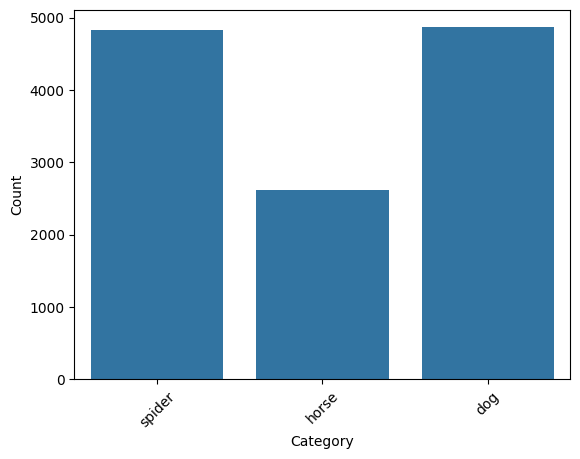

In [18]:
x_category = []
old_y_count = []

dataset_directory = 'raw-img'
list_dir = os.listdir(dataset_directory)

for category in list_dir:
    path_category = os.path.join(dataset_directory, category)
    count = len(os.listdir(path_category))

    x_category.append(category)
    old_y_count.append(count)

data_barplot = pd.DataFrame({
    'Category': x_category,
    'Count': old_y_count
})

# Plot menggunakan seaborn
sns.barplot(x='Category', y='Count', data=data_barplot)

plt.xticks(rotation=45)
plt.show()

Terlihat bahwa penyebaran data tidak merata antara ketiga label. Label dengan kategori dog dan spider memiliki jumlah yang lebih banyak dibandingkan dengan label dengan kategori horse. Kondisi ini dapat menyebabkan ketidakseimbangan pada pembelajaran model, yaitu model mungkin cenderung lebih baik dalam memprediksi kelas mayoritas daripada kelas minoritas. Untuk mengatasi masalah tersebut perlu dilakukan tahapan data augmentation. Dimana tahapan tersebut akan menghasilkan variasi dari data yang ada untuk kelas minoritas agar jumlahnya setara dengan kelas mayoritas. Sehingga akan membantu model untuk belajar dengan lebih baik dan menghasilkan prediksi yang lebih seimbang.

### **Data Augmentation dan Image Data Generator**

Data Augmentation dilakukan dengan membuat variasi baru dari setiap gambar pada dataset sehingga model memiliki lebih banyak variasi untuk dipelajari. Sehingga dapat membantu mencegah overfitting, yakni ketika model terlalu terbiasa dengan data pelatihan dan tidak dapat menggeneralisasi data baru dengan baik.

Image Data Generator digunakan untuk melakukan augmentasi dan pra-pemrosesan gambar secara otomatis selama training model. Serta dapat membagi dataset menjadi set train dan validation, serta normalisasi gambar dengan menskalakan nilai piksel.

In [19]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [20]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

horse_path = "raw-img/horse"  # Path untuk gambar asli dan hasil augmentasi
images = []  # Penyimpanan gambar yang telah melalui pra-pemrosesan

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(horse_path):
    images.append(os.path.join(horse_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image = None
        n = 0  # Variabel untuk iterasi transformasi
        transformation_count = random.randint(1, len(transformations))  # Jumlah transformasi acak

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Pilih transformasi acak
            transformed_image = transformations[key](original_image)
            n += 1

        # Simpan hasil augmentasi di direktori yang sama dengan gambar asli
        new_image_path = f"{horse_path}/augmented_image_{i}.jpg"
        transformed_image = img_as_ubyte(transformed_image)  # Konversi ke format byte
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil augmentasi
        i += 1
    except ValueError as e:
        print(f"Could not read the {image}: {e}, hence skipping it.")


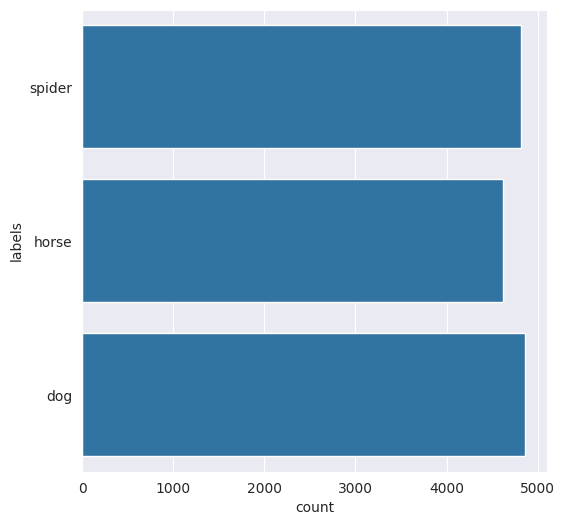

In [21]:
# Definisikan path sumber
dataset_directory = "raw-img"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(dataset_directory):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":dataset_directory, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Terlihat jumlah data pada label kategori horse telah meningkat cukup banyak sehingga tidak terlalu mencolok perbedaannya dibandingkan dengan label dog dan spider. Data sudah dapat dikatakan cukup atau bahkan sangat seimbang, sehingga proses selanjutnya dapat dilakukan.

> Menampilkan sample gambar pada tiap label animal

In [22]:
x_category = []
dataset_directory = "raw-img"
list_dir = os.listdir(dataset_directory)
for category in list_dir:
    x_category.append(category)

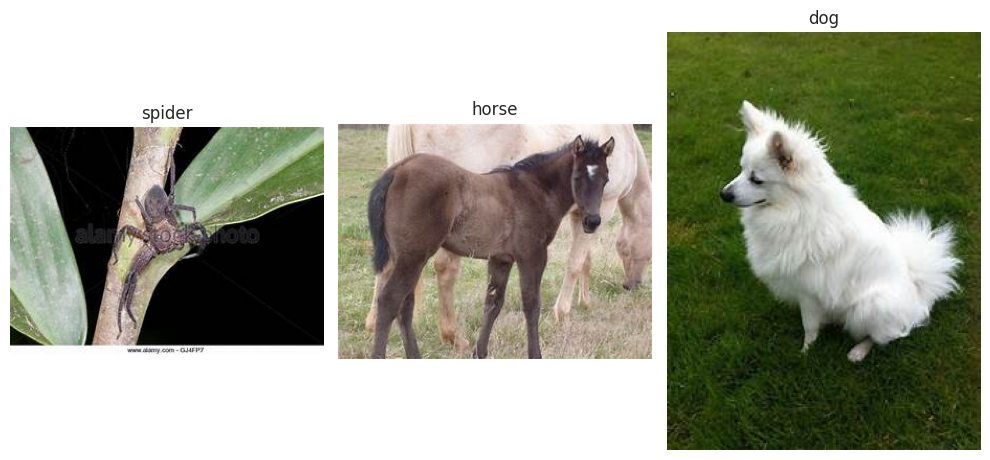

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
axes = axes.ravel()

for i, category in enumerate(x_category):
    folder_path = os.path.join(dataset_directory, category)

    image_file = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_file)

    img = Image.open(image_path)

    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Splitting Data

Membagi dataset menjadi 3 kategori yaitu training set, validation set dan testing set dengan rasio perbandingan training 80%, validation 10%, dan testing 10%.

In [24]:
def split_train_val_test(dataset_directory, train_dir, val_dir, test_dir, train_ratio=0.8, val_ratio=0.1):
    if os.path.exists(train_dir): shutil.rmtree(train_dir)
    if os.path.exists(val_dir): shutil.rmtree(val_dir)
    if os.path.exists(test_dir): shutil.rmtree(test_dir)

    os.makedirs(train_dir)
    os.makedirs(val_dir)
    os.makedirs(test_dir)

    categories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    for category in categories:
        category_path = os.path.join(dataset_directory, category)
        images = [f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)

        for i, img in enumerate(images):
            if i < train_end:
                target_folder = os.path.join(train_dir, category)
            elif i < val_end:
                target_folder = os.path.join(val_dir, category)
            else:
                target_folder = os.path.join(test_dir, category)
            os.makedirs(target_folder, exist_ok=True)
            shutil.copy(os.path.join(category_path, img), os.path.join(target_folder, img))


In [25]:
# Call split_train_val_test to create the necessary directories
split_train_val_test(
    dataset_directory='raw-img',
    train_dir='data/train',            # Create the 'data/train' directory
    val_dir='data/val',              # Create the 'data/val' directory
    test_dir='data/test'             # Create the 'data/test' directory
)

In [26]:
# Data Augmentation untuk train set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data Generator untuk validation dan test set
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Define directories explicitly
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Data Loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # atau 'binary' untuk 2 kelas
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Tidak di-shuffle agar evaluasi konsisten
)

Found 11444 images belonging to 3 classes.
Found 1430 images belonging to 3 classes.
Found 1433 images belonging to 3 classes.


## Data Modelling

In [27]:
# Menampilkan kelas (category animal) yang terdapat pada dataset
class_index = train_generator.class_indices
print(class_index)

{'dog': 0, 'horse': 1, 'spider': 2}


In [28]:
# Menggunakan model MobileNetV2 yang sudah pre-trained pada dataset ImageNet
pretrained_models = MobileNetV2(weights="imagenet",
                                include_top=False,
                                input_shape=(150,150,3)
                                )

for layer in pretrained_models.layers:
    layer.trainable = False

# Membangun model Sequential baru
model = Sequential()

# Menambahkan model pre-trained sebagai base model
model.add(pretrained_models)

# Menambahkan Convolutional 2D dan Pooling layers
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten(name="flatten"))
#model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [29]:
# Compile model dengan optimizer Adam, loss categorical_crossentropy, dan metrics accuracy
import tensorflow as tf
optimize = tf.optimizers.Adam()
model.compile(optimizer=optimize,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

> Callbacks
- untuk mencegah overfitting dengan early stopping
- untuk menyimpan model terbaik secara otomatis
- untuk mengoptimasi proses training

In [30]:
# Callbacks untuk model training yang memonitor val_accuracy dan akan berhenti apabila tidak ada perubahan selama 4 epochs.
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. ModelCheckpoint - Menyimpan model terbaik selama training
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_loss',
                             save_best_only=True,   # Hanya menyimpan model terbaik
                             mode='min'             # Mode 'min' berarti mencari nilai val_loss terkecil
                             )

# 2. EarlyStopping - Menghentikan training secara otomatis jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=4,      # Jumlah epoch tanpa peningkatan sebelum berhenti
                               min_delta=0.001, # Perubahan minimum yang dianggap sebagai peningkatan
                               restore_best_weights=True,
                               mode='max',      # Mode 'max' berarti mencari nilai val_accuracy terbesar
                               baseline=0.96    # Target minimum accuracy yang ingin dicapai
                               )

In [31]:
# Melatih model dengan konfigurasi yang telah ditentukan
num_epochs = 20

history = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=val_generator,           # Data validasi untuk evaluasi
              callbacks=[checkpoint, early_stopping],   # Callback untuk save model dan early stop
              verbose=1
              )

Epoch 1/20
358/358 [==============================] - 311s 852ms/step - loss: 0.2289 - accuracy: 0.9167 - val_loss: 0.0778 - val_accuracy: 0.9699
Epoch 2/20
358/358 [==============================] - 312s 871ms/step - loss: 0.1593 - accuracy: 0.9454 - val_loss: 0.0799 - val_accuracy: 0.9699
Epoch 3/20
358/358 [==============================] - 302s 842ms/step - loss: 0.1438 - accuracy: 0.9495 - val_loss: 0.0790 - val_accuracy: 0.9685
Epoch 4/20
358/358 [==============================] - 299s 836ms/step - loss: 0.1328 - accuracy: 0.9524 - val_loss: 0.0677 - val_accuracy: 0.9769
Epoch 5/20
358/358 [==============================] - 327s 912ms/step - loss: 0.1203 - accuracy: 0.9577 - val_loss: 0.0670 - val_accuracy: 0.9755
Epoch 6/20
358/358 [==============================] - 308s 857ms/step - loss: 0.1089 - accuracy: 0.9617 - val_loss: 0.0788 - val_accuracy: 0.9720
Epoch 7/20
358/358 [==============================] - 307s 857ms/step - loss: 0.1107 - accuracy: 0.9594 - val_loss: 0.0702 -

Hasilnya menunjukkan bahwa model memiliki performa yang sangat baik dengan akurasi pelatihan dan validasi yang konsisten tinggi (>90%) hingga epoch terakhir. Nilai loss training terus menurun, menunjukkan model belajar dengan baik dari data pelatihan. Meskipun ada sedikit fluktuasi pada loss validasi, performa keseluruhan stabil tanpa tanda overfitting yang jelas. Model ini layak digunakan untuk evaluasi lebih lanjut pada data uji.

## Evaluasi dan Visualisasi

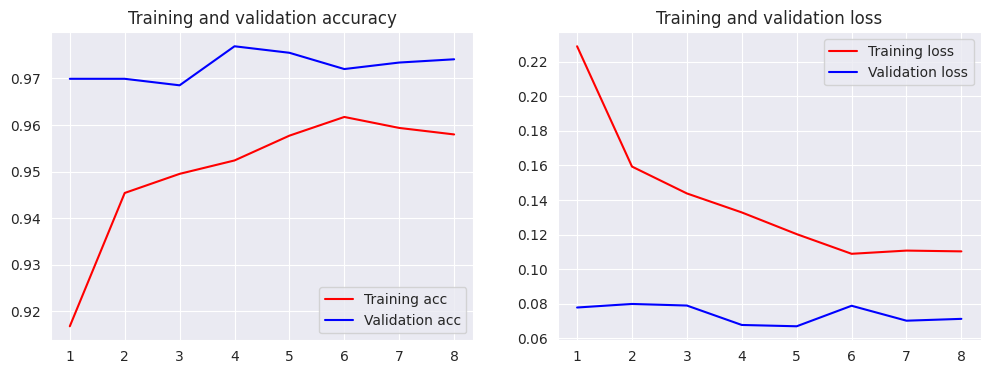

In [32]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

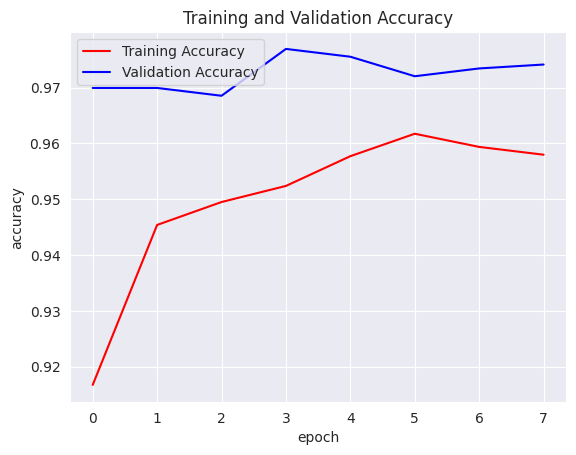

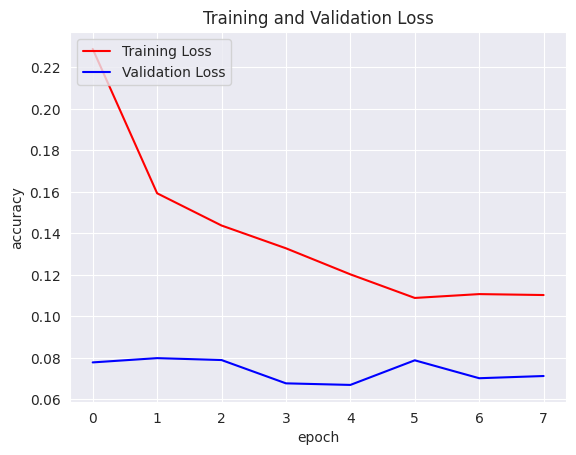

In [33]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Buat list epoch untuk sumbu x
epochs = range(len(accuracy))

# Plot untuk Grafik Akurasi
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

# Plot untuk Grafik Loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()

Dari hasil visualisasi diatas, dapat disimpulkan bahwa :
1. **Model mencapai akurasi tinggi dan stabil**  
   - Akurasi pelatihan dan validasi secara konsisten meningkat stabil selama pelatihan dengan nilai tinggi sampai di epoch akhir(>0.95) , yang menunjukkan performa yang baik. Meskipun pada akurasi validasi terlihat sedikit fluktuasi, namun masih dalam rentang normal. Sehingga Mencerminkan bahwa model mampu belajar pola dari data pelatihan dan generalisasi dengan baik pada data validasi.

2. **Loss menurun dengan baik tanpa overfitting**  
   - Nilai loss pelatihan secara konsisten menurun selama proses pelatihan, menunjukkan bahwa model terus mengurangi kesalahan prediksi. Validation loss tidak meningkat secara signifikan, yang menunjukkan bahwa model tidak mengalami overfitting. Meskipun nilai validation loss terlihat sedikit fluktuasi, namun secara keseluruhan tetap rendah. Ini menunjukkan bahwa model mampu generalisasi dengan baik.

3. **Konsistensi antara training dan validasi**  
   - Selisih kecil antara akurasi dan loss pada data training dan validasi membuktikan model tidak terlalu "menghafal" data pelatihan dan mampu menggeneralisasi dengan baik ke data baru.

In [38]:
# mengukur performa akhir model terhadap data test
model.evaluate(test_generator)

45/45 [==============================] - 28s 613ms/step - loss: 0.0825 - accuracy: 0.9672


[0.08250746876001358, 0.9672016501426697]



              precision    recall  f1-score   support

         Dog     0.9763    0.9322    0.9538       487
       Horse     0.9289    0.9870    0.9571       463
      Spider     0.9979    0.9834    0.9906       483

    accuracy                         0.9672      1433
   macro avg     0.9677    0.9676    0.9672      1433
weighted avg     0.9683    0.9672    0.9673      1433



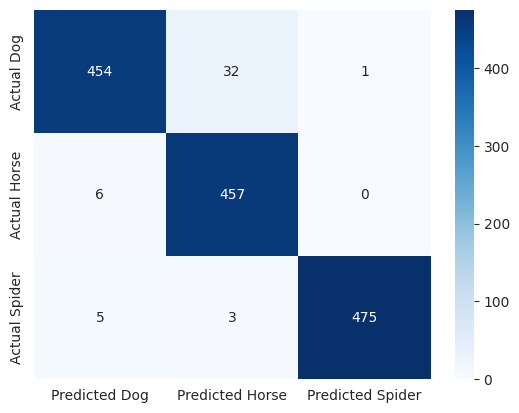

In [42]:
from sklearn.metrics import confusion_matrix, classification_report
test_generator.reset()

preds = model.predict(test_generator,verbose=0)
# Convert predicted probabilitas ke class labels
predicted_labels = np.argmax(preds, axis=1)

# Menampilkan Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_labels),
                  index=["Actual Dog", "Actual Horse", "Actual Spider"],
                  columns=["Predicted Dog", "Predicted Horse", "Predicted Spider"])
sns.heatmap(cm,annot=True, fmt="d", cmap="Blues")

# Menampilkan Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes,
                            y_pred=predicted_labels,
                            target_names =['Dog','Horse','Spider'], digits=4))

## Konversi Model

In [44]:
export_dir = 'saved_model/'

> Konversi Model ke format .h5

In [45]:
tf.saved_model.save(model, export_dir)
model.save("model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


> Konversi SavedModel => model dikonversi menjadi saved_model

In [46]:
save_model_path = os.path.join("saved_model/image_classification/")
tf.saved_model.save(model, save_model_path)

> Konversi TFJS => dimana model dikonversi menjadi format TFJS (didalamnya berisi 2 jenis file utama yaitu model.json dan file binary weights (.bin)

In [48]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model
!ls tfjs_model

2025-05-01 06:32:24.491295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746081144.516776   22448 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746081144.524381   22448 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
group1-shard1of3.bin  group1-shard2of3.bin  group1-shard3of3.bin  model.json


In [ ]:
# !tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

> Konversi TFLite => dimana model dikonversi ke dalam format TFLite

In [49]:
# Membuat folder tflite_model jika belum ada
os.makedirs('tflite_model', exist_ok=True)

# Memuat model Keras yang sudah disimpan (format .h5)
tflite_model = tf.keras.models.load_model('model.h5')

# Membuat converter untuk mengubah model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)

# Melakukan konversi model
tflite_model_convert = converter.convert()

# Menyimpan model yang sudah dikonversi ke folder tflite_model dengan nama model.tflite
tflite_path = os.path.join('tflite_model', 'model.tflite')
with open(tflite_path, "wb") as f:  # 'wb' = write binary
    f.write(tflite_model_convert)

print(f"Model berhasil dikonversi ke format TFLite dan disimpan sebagai '{tflite_path}'")

Model berhasil dikonversi ke format TFLite dan disimpan sebagai 'tflite_model/model.tflite'


> Melakukan kompres folder models dan tfjs_model ke format zip agar memudahkan untuk mendownload ke device lokal

In [50]:
# Menentukan folder yang akan di-zip
model_folder = '/content/saved_model'
tfjs_model_folder = '/content/tfjs_model'
tflite_model_folder = '/content/tflite_model'

# Menentukan nama output file zip (tanpa ekstensi .zip)
model_output = '/content/saved_model'
tfjs_model_output = '/content/tfjs_model'
tflite_output = '/content/tflite_model'

# Membuat folder jika belum ada
os.makedirs(model_folder, exist_ok=True)
os.makedirs(tfjs_model_folder, exist_ok=True)
os.makedirs(tflite_model_folder, exist_ok=True)

# Melakukan proses zip pada folder models
shutil.make_archive(
    model_output,
    'zip',
    model_folder
)

# Melakukan proses zip pada folder tfjs_model
shutil.make_archive(
    tfjs_model_output,
    'zip',
    tfjs_model_folder
)

# Melakukan proses zip pada folder tflite_model
shutil.make_archive(
    tflite_output,
    'zip',
    tflite_model_folder
)

print("Proses kompresi folder models, tfjs_model, dan tflite_model berhasil dilakukan")

Proses kompresi folder models, tfjs_model, dan tflite_model berhasil dilakukan


Membuat file requirements.txt untuk menghasilkan daftar semua library Python yang diinstal di lingkungan saat ini beserta versinya.

In [51]:
!pip freeze > requirements.txt

## Inference (Optional)

Melakukan inference model untuk membuat prediksi pada data baru dengan menggunakan model machine learning yang telah dilatih.

In [52]:
# Buat direktori 'gambar' jika belum ada
os.makedirs('gambar', exist_ok=True)
print("Direktori 'gambar' berhasil dibuat!")

Direktori 'gambar' berhasil dibuat!


In [58]:
from google.colab import files

# Mengupload file gambar ke dalam folder gambar yang telah dibuat
def upload_images():
    uploaded = files.upload()
    for filename in uploaded.keys():
        # Pindahkan file ke folder gambar
        shutil.move(filename, f"gambar/{filename}")
        print(f"File {filename} berhasil diupload ke folder gambar/")

# Jalankan fungsi upload
upload_images()

Saving spiderr.jpg to spiderr.jpg
File spiderr.jpg berhasil diupload ke folder gambar/


In [59]:
import os

# Cek apakah folder 'gambar' ada
if not os.path.exists('gambar'):
    print("ERROR: Folder 'gambar' tidak ditemukan!")
    os.makedirs('gambar', exist_ok=True)  # Otomatis buat folder jika mau
else:
    print("Isi folder 'gambar':", os.listdir('gambar'))

Isi folder 'gambar': ['dog.jpg', 'horse.jpg', 'horsee.jpg', 'spider.jpg', 'spiderr.jpg', 'dogg.jpg']


In [60]:
#  Buat file .txt untuk menyimpan konten
name_file_path = "/content/tflite_model/imageClassification.txt"

# Konten berupa teks yang akan ditulis ke dalam file untuk membantu dalam prediksi
contents = """Dog
Horse
Spider"""

# Tulis konten ke dalam file
with open(name_file_path, "w") as file:
    file.write(contents)

In [61]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

# 1. LOAD MODEL DAN LABEL
# Memuat model TFLite yang sudah dikonversi
interprete = tf.lite.Interpreter(model_path='/content/tflite_model/model.tflite')
interprete.allocate_tensors()  # Alokasi memori untuk model

# Mendapatkan detail input/output model
input_details = interprete.get_input_details()
output_details = interprete.get_output_details()
input_shape = input_details[0]['shape']  # Bentuk input yang diharapkan model

# Memuat daftar nama kelas dari file teks
with open('/content/tflite_model/imageClassification.txt') as f:
    class_names = [line.strip() for line in f.readlines()]

# 2. PREPARASI DATA
# Mencari semua file gambar di folder target
image_folder = '/content/gambar'
image_files = [f for f in os.listdir(image_folder)
              if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]

# Handle jika folder kosong
if not image_files:
    print("Tidak ada file gambar yang ditemukan di folder /content/gambar/")
else:
    print(f"Menemukan {len(image_files)} gambar untuk diprediksi:")
    print(", ".join(image_files))

# 3. PROSES INFERENSI
for img_file in image_files:
    try:
        # PREPROCESSING
        img_path = os.path.join(image_folder, img_file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((input_shape[1], input_shape[2]))
        input_data = np.array(img, dtype=np.float32)[np.newaxis, ...] / 255.0  # Normalisasi [0,1]

        # INFERENSI
        interprete.set_tensor(input_details[0]['index'], input_data)  # Set input
        interprete.invoke()  # Eksekusi model

        # POSTPROCESSING
        output_data = interprete.get_tensor(output_details[0]['index'])
        predicted_class = np.argmax(output_data)  # Kelas dengan probabilitas tertinggi
        confidence = np.max(output_data)  # Nilai confidence

        # TAMPILKAN HASIL
        print(f"\nFile: {img_file}")
        print(f"Predicted: {class_names[predicted_class]} (Confidence: {confidence:.2%})")

        # Tampilkan probabilitas semua kelas (opsional)
        print("Detail Probabilitas:")
        for i, prob in enumerate(output_data[0]):
            print(f"  {class_names[i]}: {prob:.2%}")

    except Exception as e:
        print(f"\nError memproses {img_file}: {str(e)}")

Menemukan 6 gambar untuk diprediksi:
dog.jpg, horse.jpg, horsee.jpg, spider.jpg, spiderr.jpg, dogg.jpg

File: dog.jpg
Predicted: Dog (Confidence: 99.98%)
Detail Probabilitas:
  Dog: 99.98%
  Horse: 0.02%
  Spider: 0.00%

File: horse.jpg
Predicted: Horse (Confidence: 99.99%)
Detail Probabilitas:
  Dog: 0.01%
  Horse: 99.99%
  Spider: 0.00%

File: horsee.jpg
Predicted: Horse (Confidence: 99.96%)
Detail Probabilitas:
  Dog: 0.04%
  Horse: 99.96%
  Spider: 0.00%

File: spider.jpg
Predicted: Spider (Confidence: 99.92%)
Detail Probabilitas:
  Dog: 0.07%
  Horse: 0.01%
  Spider: 99.92%

File: spiderr.jpg
Predicted: Spider (Confidence: 99.99%)
Detail Probabilitas:
  Dog: 0.00%
  Horse: 0.00%
  Spider: 99.99%

File: dogg.jpg
Predicted: Dog (Confidence: 100.00%)
Detail Probabilitas:
  Dog: 100.00%
  Horse: 0.00%
  Spider: 0.00%


Kesimpulan dari hasil prediksi yang telah dilakukan sebagai berikut :

**Hasil prediksi menunjukkan akurasi yang sangat tinggi dengan confidence level 100% untuk beberapa gambar, membuktikan model dapat mengklasifikasikan semua kelas/kategori dengan sangat baik.** Bahkan pada variasi penulisan nama file yang tidak standar seperti 'dogg.jpg', 'spiderr.jpg', dan 'horsee.jpg', model tetap mampu mengenali objek utama dengan confidence di atas 99%, hal ini menunjukkan robustnes yang baik terhadap minor noise dalam input.

**Model secara konsisten memberikan probabilitas dominan yang sangat tinggi (>99%) untuk kelas yang benar, sementara probabilitas untuk kelas lain kecil**, hal ini mengindikasikan kemampuan pembeda (discriminative power) yang sangat kuat antar kelas/kategori animal.